# R analysis for credibility of domains

In [ ]:
library(tidyverse)
library(ggplot2)
library(stats)
#library(arrow)
#library(rvest)
library(R.utils)
library(vtable)
library(xtable)
library(DescTools)
library(cowplot)

In [ ]:
newsguard_raw <- read_csv("../../data/newsguard_metadata_Sep21.csv")

newsguard <- newsguard_raw%>%
rename("mini_domain" = Domain, "parent_domain" = `Parent Domain`, "ng_score" = Score)%>%
#filter(Country == "US")%>%
select(mini_domain, parent_domain, Country, ng_score)%>%
pivot_longer(ends_with("domain"),names_to = "domain_type", values_to = "domain")%>%
drop_na()%>%
filter(!(domain == "vice.com" & Country %in% c("IT", "DE","FR", "ALL")))%>%
filter(!(domain == "msn.com" & Country %in% c("IT", "DE","FR", "ALL")))%>%
select(-domain_type, -Country)%>%
distinct() 

type_df<-read_csv("../../data/house_analysis/domain_isnews_islocal_ispolicontrol.csv")%>% 
left_join(newsguard) %>%
mutate(low_cred = ifelse(ng_score < 60, 1, 0), 
       cmpt_rank = cmpt_rank+1,
       weighted_sum= cmpt_rank*counts)

type_sum <- type_df %>%
mutate(local_include = ifelse(is.na(classification) ==FALSE, 1,0),
      #cmpt_rank = cmpt_rank+1,
       #weighted_sum= cmpt_rank
       total_prop_news = (counts/sum(type_df%>%filter(category == "news") %>%pull(counts)))*100,
      total_prop = (counts/sum(type_df$counts))*100,
      is_news = factor(ifelse(is_news == TRUE, "News\n(29.7% of All Results)", "Not News\n(70.3% of All Results)"),
                      levels = c( "News\n(29.7% of All Results)", "Not News\n(70.3% of All Results)")),
      is_poli_control = factor(ifelse(is_poli_control == TRUE, "Politician Controllled\n(37.5% of All Results)", 
                                      "Not Politician Controllled\n(62.5% of All Results)"),
                      levels = c( "Politician Controllled\n(37.5% of All Results)", 
                                 "Not Politician Controllled\n(62.5% of All Results)")),
      classification_labelled = case_when(
          classification == "national" ~ "National News\n(25.6% of News Results)",
          classification == "local" ~ "Local News\n(62.5% of News Results)",
          TRUE ~ NA),
        low_cred = factor(ifelse(low_cred == 1, "Low Credibility News\n(0.6% of News Results)", 
                                      "High Credibility News\n(76.5% of News Results)"),
                      levels = c( "High Credibility News\n(76.5% of News Results)", 
                                 "Low Credibility News\n(0.6% of News Results)")))


In [34]:
head(type_df)

domain,cmpt_rank,is_home_district,category,counts,classification,is_news,is_local,is_poli_control,rank,ng_score,low_cred,weighted_sum
<chr>,<dbl>,<lgl>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
1011now.com,1,FALSE,news,1,local,TRUE,TRUE,FALSE,1,92.5,0,1
1011now.com,2,FALSE,news,531,local,TRUE,TRUE,FALSE,2,92.5,0,1062
1011now.com,2,TRUE,news,2,local,TRUE,TRUE,FALSE,2,92.5,0,4
1011now.com,3,FALSE,news,255,local,TRUE,TRUE,FALSE,3,92.5,0,765
1011now.com,3,TRUE,news,1,local,TRUE,TRUE,FALSE,3,92.5,0,3
1011now.com,4,FALSE,news,5234,local,TRUE,TRUE,FALSE,4,92.5,0,20936


In [ ]:
type_df_domain <- type_df%>% group_by(domain)%>%
summarise(is_local = mean(is_local),
         low_cred = mean(low_cred),
         is_news = mean(is_news),
         is_poli_control = mean(is_poli_control))
type_df_domain2 <- type_df%>% select(domain, category)%>%
distinct()

dem_rep_news <- read_csv("../../data/house_analysis/house_party_domain_no_duplicate.csv")%>%
left_join(type_df_domain)%>%
left_join(type_df_domain2)


In [87]:
dem_rep_sum1 <- dem_rep_news %>%
select(-is_news, -is_poli_control)%>%
filter(category == "news")%>%
mutate(is_local = case_when(
          is_local == 1 ~ "National\nNews",
          is_local == 0 ~ "Local\nNews",
          TRUE ~ "No\nClassification"),
       low_cred = case_when(
          low_cred == 1 ~ "Low\nCredibility",
          low_cred == 0 ~ "High\nCredibility",
          TRUE ~ "No\nClassification")) %>%
pivot_longer(c("is_local", "low_cred"), names_to = "group", values_to = "value")%>%
group_by(party, group, value) %>%
summarise(group_counts = sum(counts))

dem_rep_sum2 <- dem_rep_news %>%
select(-is_local, -low_cred)%>%
mutate(is_news = factor(ifelse(is_news == TRUE, "News", "Not News"),
                      levels = c( "News", "Not News")),
      is_poli_control = factor(ifelse(is_poli_control == TRUE, "Politician\nControllled", 
                                      "Not Politician\nControllled"),
                      levels = c( "Politician\nControllled", 
                                 "Not Politician\nControllled")))%>%
pivot_longer(c("is_poli_control", "is_news"), names_to = "group", values_to = "value")%>%
group_by(party, group, value) %>%
summarise(group_counts = sum(counts))

dem_rep_sum<- rbind(dem_rep_sum1, dem_rep_sum2)%>%
group_by(party,group)%>%
mutate(total_counts = sum(group_counts), 
       group_prop = group_counts/total_counts,
      party_label = ifelse(party == "Democrat", " Search Results for Democratic members", 
                           "Search Results for Republican members"))%>%
filter(party!= "Independent")

`summarise()` has grouped output by 'party', 'group'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'party', 'group'. You can override using
the `.groups` argument.


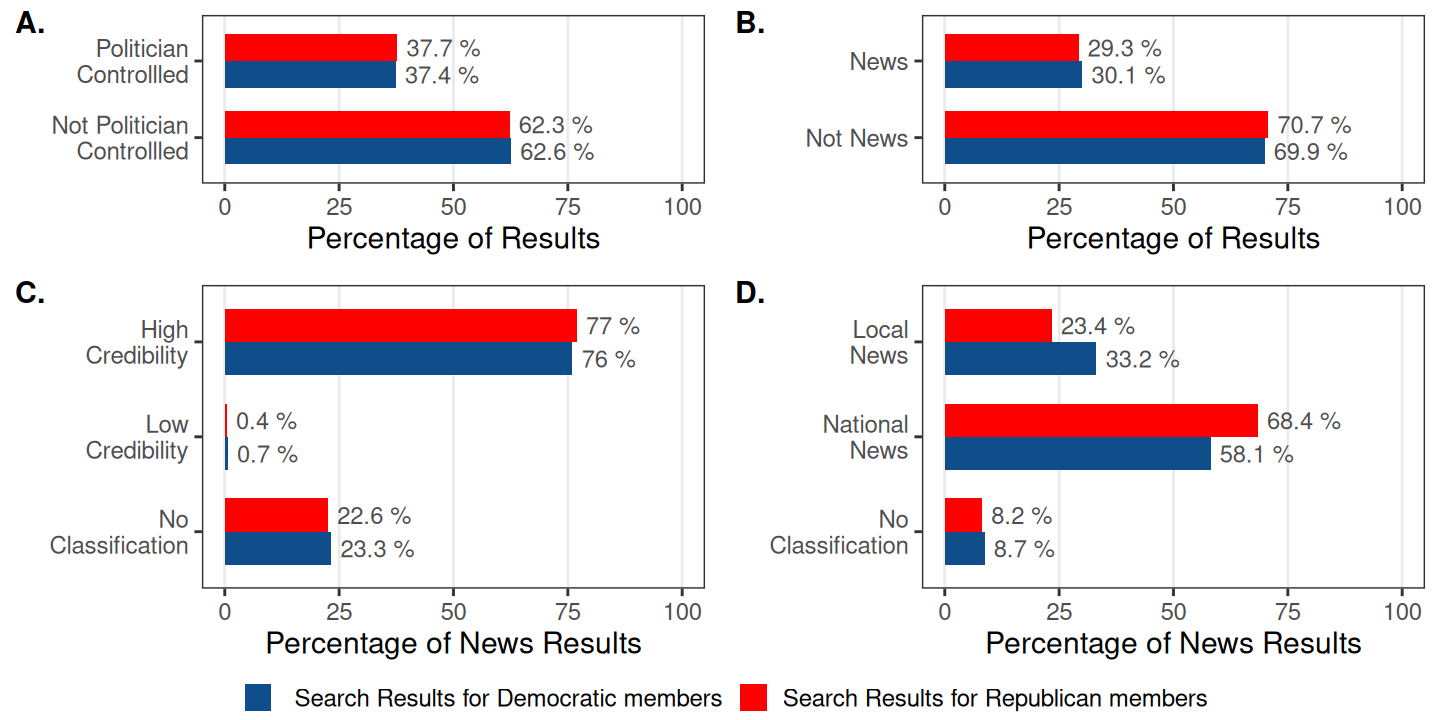

In [115]:
options(repr.plot.width=12, repr.plot.height=6)
library(ggpubr)
get_partisan_plot <- function(varname){
    plot<- ggplot(dem_rep_sum %>% filter(group==varname), 
       aes(x= group_prop*100, y = factor(value), fill = party_label,
          label = paste(round(group_prop*100, digits = 1), "%")))+
geom_col(position = "dodge", width = 0.7)+
geom_text(aes(x = (group_prop*100)+2 ),hjust = 0, color = "gray30", size = 5, 
          position = position_dodge(width = .7))+
scale_x_continuous(limits = c(0,100))+
scale_fill_manual(values = c( "dodgerblue4","red"))+ 
#labs(y = "", x = "Percentage of Results", fill = "")+
    theme_bw(base_size = 18)+
theme(legend.position = "top", 
      panel.grid.minor = element_blank(), 
      panel.grid.major.y = element_blank())
    return(plot)
}

plot1<- get_partisan_plot("is_poli_control")+
labs(y = "", x = "Percentage of Results", fill = "")

plot2<- get_partisan_plot("is_news")+
labs(y = "", x = "Percentage of Results", fill = "")+
scale_y_discrete(limits=rev)

plot3<- get_partisan_plot("low_cred")+
labs(y = "", x = "Percentage of News Results", fill = "")+
scale_y_discrete(limits=rev)

plot4<- get_partisan_plot("is_local")+
labs(y = "", x = "Percentage of News Results", fill = "")+
scale_y_discrete(limits=rev)

legend <- get_legend(plot1)

plot_group <- plot_grid(plot1+ theme(legend.position = "none"), 
                        plot2 + theme(legend.position = "none"), 
                        plot3 + theme(legend.position = "none"), 
                        plot4 + theme(legend.position = "none"), 
                        ncol = 2, align="v", 
          labels = c('A.','B.','C.', 'D.'),
          label_size = 18,
          rel_heights = c(2,3))

plot_grid(plot_group, legend, ncol = 1, rel_heights = c(15,1))
ggsave("../../data/plots/si_partisan.pdf", width = 12, height = 8, units = "in")

In [110]:
legend

TableGrob (5 x 5) "guide-box": 2 grobs
  z     cells                  name           grob
1 1 (3-3,3-3)                guides gtable[layout]
2 0 (2-4,2-4) legend.box.background zeroGrob[NULL]

In [101]:
install.packages("ggpubr")

Installing package into ‘/home/aywan/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Deriv’, ‘microbenchmark’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘corrplot’, ‘car’, ‘ggsci’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’




In [96]:
legend

zeroGrob[NULL] 

`summarise()` has grouped output by 'cmpt_rank'. You can override using the
`.groups` argument.
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_col()`).”
Warning message:
“Removed 28 rows containing missing values or values outside the scale range
(`geom_label()`).”


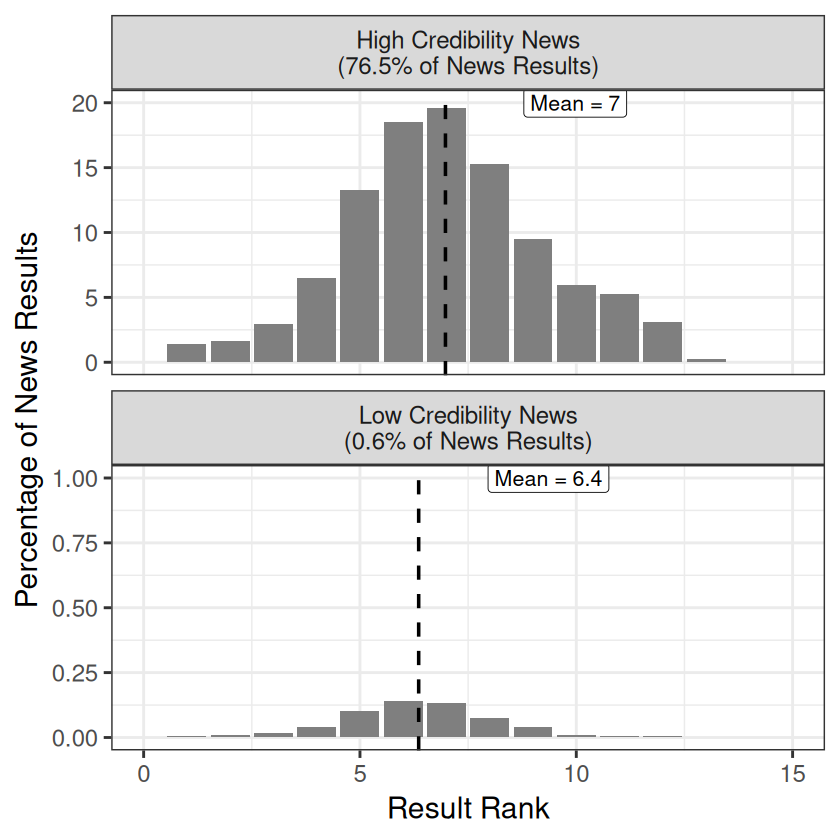

In [47]:
plot4_df <- type_sum %>% 
select(total_prop_news,cmpt_rank,low_cred,counts )%>% 
       filter(is.na(low_cred) == FALSE )%>%
       group_by(cmpt_rank,low_cred)%>%
       summarise(n = sum(total_prop_news, na.rm = TRUE),
                 n_counts = sum(counts, na.rm = TRUE)) %>%
              group_by(low_cred)%>%
               mutate(group_counts = sum(n_counts),
                   mean_rank = sum(cmpt_rank*n_counts)/group_counts,
                     mean_label = ifelse(cmpt_rank == ceiling(mean_rank), 
                                         paste0("Mean = ", as.character(round(mean_rank, 1))),NA),
                     y_lab = ifelse(low_cred ==  "Low Credibility News\n(0.6% of News Results)", 
                                    1, 20))

ggplot(plot4_df,
       aes(y = n, x = cmpt_rank))+
geom_col(fill = "gray50")+
geom_vline(linetype = "dashed", linewidth = 1, aes(xintercept = mean_rank))+
geom_label(aes(label = mean_label, x = mean_rank +3, y = y_lab), label.size = 0.25, size = 4.5)+
scale_x_continuous(limits = c(0,15))+
facet_wrap(~low_cred, ncol = 1, scales = "free_y")+
labs(y = "Percentage of News Results", x = "Result Rank")+
theme_bw(base_size = 18)+
theme(legend.position="none")